In [1]:
# pip install 'pyvista[all]'

import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../'))
from utils.multiview_utils import MultiviewVids
from configs.arguments import get_config_dict
from utils.io_utils import load_json
import cv2

# set up arguments
arv_copy = sys.argv
sys.argv = ['pop']
sys.argv.append('-cfg')
config_path = os.path.abspath('../../project_config.yaml')
sys.argv.append(config_path)
sys.argv.append('-dr')
root_path = os.path.abspath('../../data/')
sys.argv.append(root_path)
sys.argv.append('-l')
sys.argv.append('info')

# load arguments from the arg parser
config = get_config_dict()
data_root = config["main"]["data_root"]
calib_dir = os.path.join(data_root, '0-calibration', 'calibs')
video_dir = os.path.join(data_root, 'raw_data', 'footage')
reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'reconstruction.json')
omni_tag = '360'

mvvids = MultiviewVids(newest=False, config=config)

max_frame = np.min([10, mvvids.get_max_frame_id() - 1])
step = 2
base_frames = {}

frame_ids = list(np.arange(0, max_frame, step))

# base_frames = mvvids.extract_mv(frame_ids, undistort = True)
base_frames = {cam_name: [] for cam_name in mvvids.cam_names}
for image in os.listdir(os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'images')):
    if image.endswith('.jpg') and '360' not in image:
        # image_id = int(image.split('.')[0])
        cam_name = image.split('_')[0]
        base_frames[cam_name].append(cv2.imread(os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'images', image)))
        # if image_id in frame_ids:
        #     base_frames[image_id] = os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', image

# Load reconstruction
reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction.json')
if not os.path.exists(reconstruction_dir):
    print( "Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.")
    
reconstruction = load_json(reconstruction_dir)[0]

10:25:39.595 - [            0-calibration/arguments.py:093] - DEBUG    - No training config file specified, using default config in data_root/2-training/train_config.yaml
10:25:39.597 - [      0-calibration/multiview_utils.py:894] - INFO     - Cameras: ['cam1', 'cam2', 'cam3', 'cam4']
10:25:41.265 - [      0-calibration/multiview_utils.py:902] - INFO     - Loading calibration data for camera 'cam1'
10:25:42.890 - [      0-calibration/multiview_utils.py:902] - INFO     - Loading calibration data for camera 'cam2'
10:25:44.512 - [      0-calibration/multiview_utils.py:288] - WARNING  - Discarding frame IDs {0} that are out of range.
10:25:44.587 - [      0-calibration/multiview_utils.py:682] - WARNING  - Unable to read JSON /Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/0-calibration/calibs/cam4.json, initialising with default values
10:25:44.588 - [      0-calibration/multiview_utils.py:684] - WARNING  - list index out of range


In [3]:
sys.argv = arv_copy
import numpy as np
import copy
import pyvista as pv
import cv2
import sys
import os
sys.path.append('..')

from scipy.spatial.transform import Rotation as R
from utils.plot_utils import rotation_matrix
from utils.io_utils import write_json

from utils.coordinate_utils import update_reconstruction, project_to_ground_plane_cv2

# Extract coordinates and remove outliers
plot_recon = [reconstruction['points'][i]['coordinates'] for i in reconstruction['points'].keys()]
plot_recon = np.array(plot_recon)
dist = np.linalg.norm(plot_recon - np.mean(plot_recon, axis=0), axis=1)
plot_recon = plot_recon[dist < 2 * np.std(dist)]

# Update camera calibrations and get camera positions
camera_centers = []
for camera in mvvids.cams:
    camera.calib_from_reconstruction(reconstruction=reconstruction)
    camera_centers.append(camera.get_position())

curr_normal = [0,0,1]
curr_origin = [0,0,0]

# Create a plotter object
plotter = pv.Plotter(shape=(1,2))

# Add your objects to the plotter
# For example, create and add a plane
# plane = pv.Plane(center=(0, 0, 0), direction=(0, 0, 1))

sample = np.random.choice(plot_recon.shape[0], 
                          500, replace=False)

point_cloud = pv.PolyData(plot_recon[sample])
camera_locations = pv.PolyData(camera_centers)

plotter.subplot(0,0)

plotter.add_mesh(point_cloud, color='blue', point_size=5)
plotter.add_mesh(camera_locations, color='red', point_size=10)
imgs = [cv2.resize(base_frames[camera.name][0], camera.calibration.size) for camera in mvvids.cams]


def callback(normal, origin):
    global curr_normal, curr_origin
    global temp_reconstruction
    curr_normal = normal
    curr_origin = origin
    plotter.subplot(0,1)

    rotation = R.from_matrix(rotation_matrix(curr_normal, [0,0,1]))

    temp_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation, origin=curr_origin, scaling = 1)

    part_img = []

    for i, cam in enumerate(mvvids.cams):
        cam.calib_from_reconstruction(reconstruction = temp_reconstruction)
        H = cam.get_ground_plane_homography(input_img_size = cam.calibration.size, output_img_size = (1920, 1080))

        part_img.append(project_to_ground_plane_cv2(imgs[i], H, (1920, 1080)))
    
    # new_img = np.zeros((1920, 1080, 3), dtype=np.uint8)
    new_img = None
    for img_ in part_img:
        # convert to RGB
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        if isinstance(new_img, np.ndarray):
            new_img = cv2.addWeighted(new_img, 0.5, img_, 0.5, 0)
        else:
            new_img = img_
    plotter.subplot(0,1)

    # Create a plane to which the texture will be mapped
    plane = pv.Plane(direction=(0, 0, 1), i_size=new_img.shape[1], j_size=new_img.shape[0])


    texture = pv.numpy_to_texture(new_img)
    plotter.add_mesh(plane, texture = texture)

def key_press_event(vtk_obj, event):
    global curr_normal, curr_origin
    if vtk_obj.GetKeyCode() == 'r':
        print('Resetting...')
        curr_normal = [0,0,1]
        curr_origin = [0,0,0]
        callback(curr_normal, curr_origin)
    elif vtk_obj.GetKeyCode() == 's':
        print('Saving reconstruction...')
        write_json(os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'reconstruction_test.json'), temp_reconstruction)
        
plotter.subplot(0,1)
plotter.camera_position = [(0, 0, 2000), (0, 0, 0), (0, 2000, 0)]
plotter.enable_camera_rotation = False
plotter.enable_zoom = False
plotter.enable_pan = False

plotter.subplot(0,0)     
plotter.add_plane_widget(callback, normal=[0,0,1])


# # Show the plotter
plotter.show()



Widget(value='<iframe src="http://localhost:52934/index.html?ui=P_0x29f941a80_0&reconnect=auto" class="pyvista…

Dropdown(description='Camera:', options=('cam1', 'cam2'), value='cam1')

Button(description='Save Data', style=ButtonStyle())

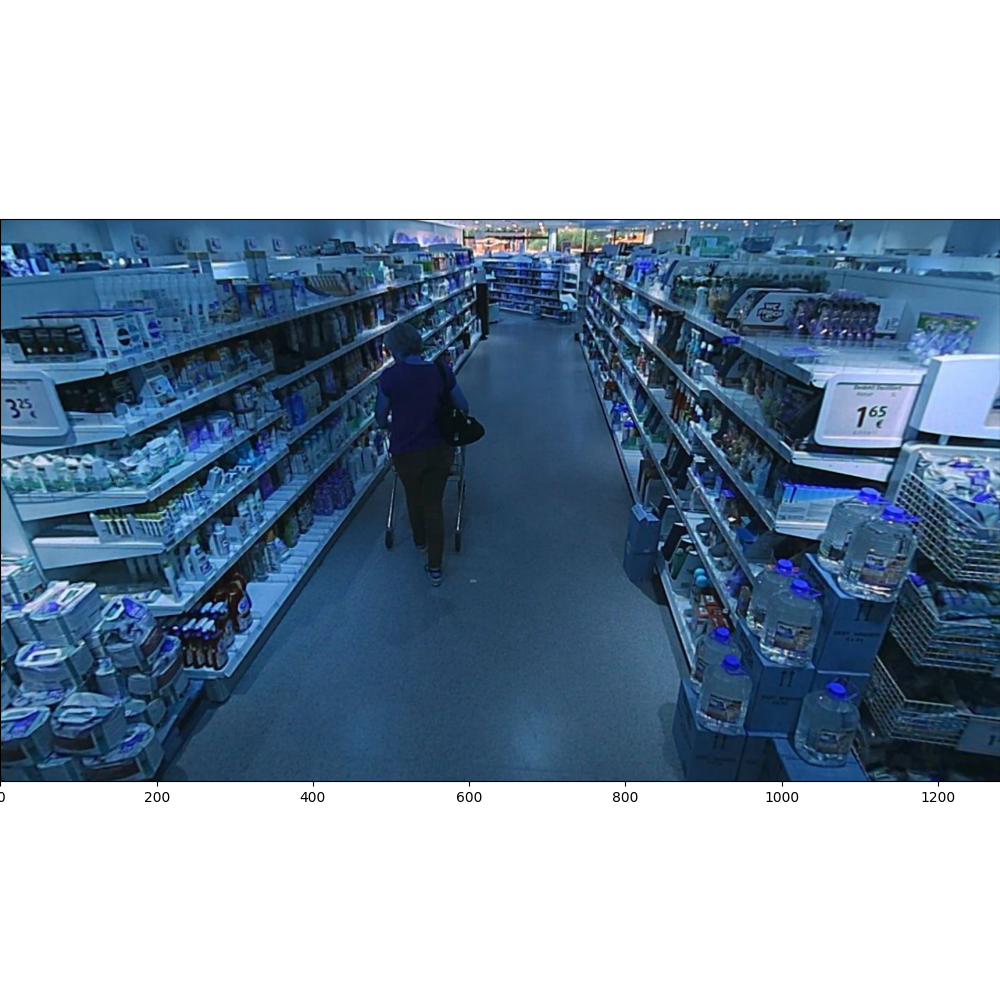

Saving calibration data for camera: cam1
ROI not defined for camera: cam2


In [10]:
import matplotlib.pyplot as plt
plt.close('all')
import ipywidgets as widgets
import os
from matplotlib.patches import Polygon
from pathlib import Path
%matplotlib widget

# Load reconstruction
reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction.json')
if not os.path.exists(reconstruction_dir):
    print( "Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.")
    
reconstruction = load_json(reconstruction_dir)[0]


roi_points = {cam.name: [] for cam in mvvids.cams}

# create dropdown widget with camera names as options
cam_dropdown = widgets.Dropdown(
    options=[cam.name for cam in mvvids.cams],
    value=mvvids.cams[0].name,
    description='Camera:',
)

def onclick(event, cam):
    ax_roi.plot(event.xdata, event.ydata, 'rx', markersize=10)
    roi_points[cam.name].append(([event.xdata, event.ydata]))

    # check if we have at least 3 points to define a polygon
    if len(roi_points[cam.name]) >= 3:
        # get the x and y coordinates of the clicked points
        x, y = zip(*roi_points[cam.name])

        # create a polygon patch with the clicked points
        polygon = Polygon(list(zip(x, y)), alpha=0.2, facecolor='C0')

        # remove any existing polygon patches from the axes
        for patch in ax_roi.patches:
            patch.remove()

        # add the new polygon patch to the axes
        ax_roi.add_patch(polygon)

    fig_roi.canvas.draw()

def update_cam(change):
    ax_roi.cla()
    global cam
    cam_name = change.new
    cam = next(cam for cam in mvvids.cams if cam.name == cam_name)
    ax_roi.set_title(f"Camera: {cam.name}")
    ax_roi.imshow(base_frames[cam.name][0])
    fig_roi.canvas.draw()

cam_dropdown.observe(update_cam, names='value')

cam = mvvids.cams[0]
fig_roi, ax_roi = plt.subplots(1,1, figsize=(10,10))
ax_roi.imshow(base_frames[cam.name][0])
fig_roi.subplots_adjust(left=0, right=1, bottom=0, top=1)

cid = fig_roi.canvas.mpl_connect('button_press_event', lambda event: onclick(event, cam))

display(cam_dropdown)

# Create a button for saving the data
save_button = widgets.Button(description="Save Data")
display(save_button)

# Define the button click event
def on_button_clicked(b):
    
    # Save updated calibrations
    for camera in mvvids.cams:
        if not roi_points[camera.name]:
            print(f"ROI not defined for camera: {camera.name}")
            continue
        print(f"Saving calibration data for camera: {camera.name}")
        camera.calib_from_reconstruction(reconstruction = temp_reconstruction)
        camera.calib_path =  Path(data_root) / '0-calibration' / 'calibs' / f'{camera.name}_new.json'
        camera.calibration = camera.calibration._replace(ROI = roi_points[camera.name])
    for camera in mvvids.cams:
        if not roi_points[camera.name]:
            continue
        rect, _ = mvvids.get_bounding_box(reconstruction=temp_reconstruction)
        camera.calibration = camera.calibration._replace(bounding_box = rect)
        camera.save_calibration(calibration = camera.calibration)

save_button.on_click(on_button_clicked)
# display(fig)

Text(value='500.0', description='Known Distance:', placeholder='Enter known distance')

Button(description='Save Data', style=ButtonStyle())

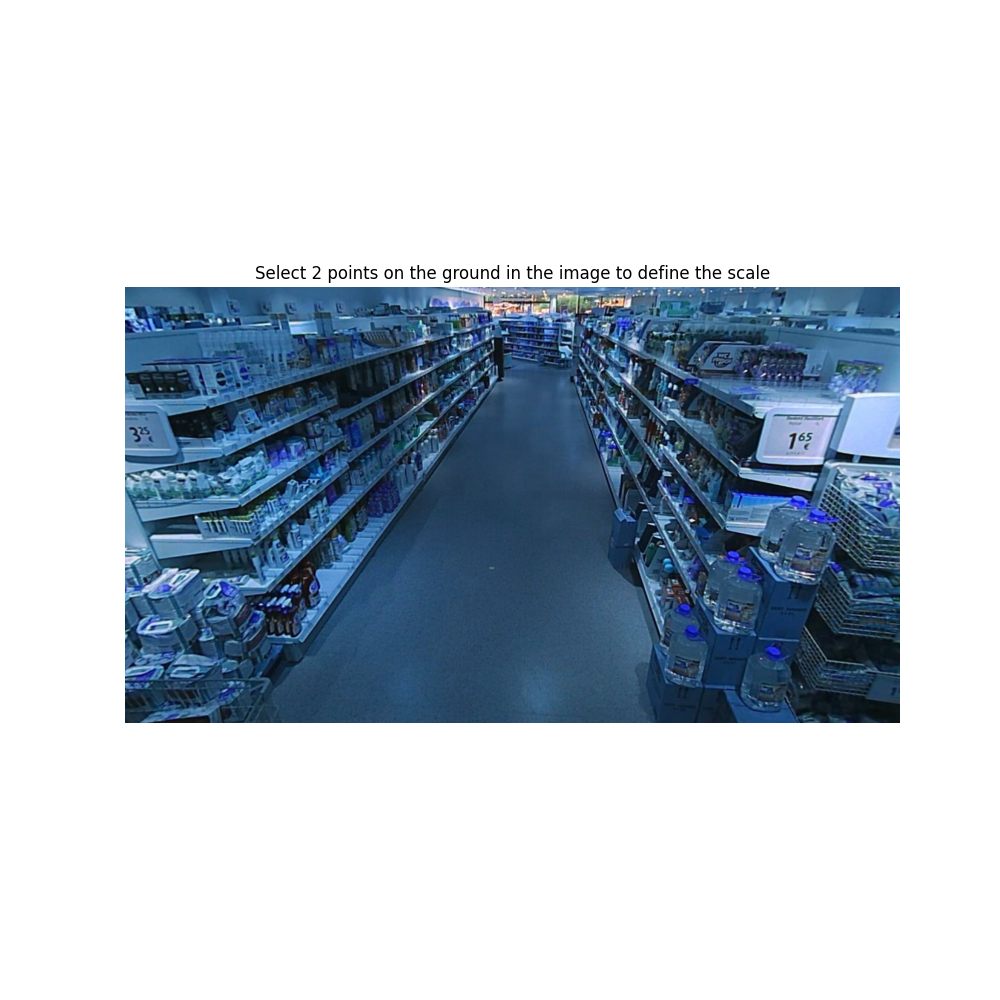

38.96712242773967
Saving calibration data for camera: cam1
Saving calibration data for camera: cam2
3.3399611488640635
Saving calibration data for camera: cam1
Saving calibration data for camera: cam2
389.67122427745267
Saving calibration data for camera: cam1
Saving calibration data for camera: cam2


In [13]:
# Select 2 points on the ground in the image to define the scale
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display

from skspatial.objects import Points, Plane

import sys
sys.path.append('..')

from utils.plot_utils import get_scale

# Create a text box for known_distance
known_distance_text = widgets.Text(
    value='500.0',
    placeholder='Enter known distance',
    description='Known Distance:',
    disabled=False
)
display(known_distance_text)

fig_scale, ax = plt.subplots(1,1, figsize=(10,10))
cam = mvvids.cams[0]
frame_num = len(base_frames[cam.name]) - 1
img = copy.deepcopy(base_frames[cam.name][frame_num])

ax.imshow(img)
ax.set_title(f"Select 2 points on the ground in the image to define the scale")
ax.axis('off')

# Create a button for saving the data
save_button = widgets.Button(description="Save Data")
display(save_button)

# Define the button click event
def on_button_clicked(b):
    
    known_distance = float(known_distance_text.value)
    scale_info = {'id': cam.calibration.view_id,'distance': known_distance, 
              'point1': first_point, 'point2': second_point}
    ground_plane = Plane([0,0,0], [0,0,1])
    scale = get_scale(scale_info, mvvids, ground_plane)
    print(scale)
    # Save updated reconstruction
    temp_reconstruction = update_reconstruction(copy.deepcopy(reconstruction),scaling = scale)
    new_reconstruction_path = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction_new.json')
    write_json(new_reconstruction_path, [temp_reconstruction])

    # Save updated calibrations
    for camera in mvvids.cams:
        print(f"Saving calibration data for camera: {camera.name}")
        camera.calib_from_reconstruction(reconstruction = temp_reconstruction)
        camera.calib_path =  Path(data_root) / '0-calibration' / 'calibs' / f'{camera.name}_new.json'
        camera.calibration = camera.calibration._replace(ROI = roi_points[camera.name])
        rect, _ = mvvids.get_bounding_box(reconstruction=temp_reconstruction)
        camera.calibration = camera.calibration._replace(bounding_box = rect)
        camera.save_calibration(calibration = camera.calibration)

save_button.on_click(on_button_clicked)


cam_center = cam.get_position()
first_point = None
second_point = None
scale_info = {}
distance = known_distance_text.value
def onclick3(event):
    known_distance = float(known_distance_text.value)
    global first_point
    global second_point
    global distance
    global scale_info
    x, y = event.xdata, event.ydata
    
    if first_point is None:
        # find the 3D point on the ground plane
        first_point = (x, y)
        ax.plot(x, y, 'rx')
    elif second_point is None:
        second_point = (x, y)
        ax.plot(x, y, 'bx')
    
    scale_info = {'id': cam.calibration.view_id,'distance': known_distance, 
              'point1': first_point, 'point2': second_point}

    ax.imshow(img)
    fig_scale.canvas.draw()



cid = fig_scale.canvas.mpl_connect('button_press_event', onclick3)




In [3]:
# import os
# import sys
# import numpy as np
# import json

# sys.path.append('..')
# from configs.arguments import get_config_dict
# from utils.multiview_utils import Camera, Calibration, MultiviewVids
# from utils.io_utils import write_json, load_json
# from utils.metadata_utils import get_cam_names
# from utils.coordinate_utils import update_reconstruction, point_in_polygon, project_to_ground_plane_cv2
# from utils.plot_utils import rotation_matrix, perp

# from scipy.spatial.transform import Rotation as R
# from skspatial.objects import Point, Vector, Plane, Points, Line
# import pyransac3d as pyrsc

# import copy
# import cv2
# import ipywidgets as widgets
# import ipympl
# import matplotlib.pyplot as plt

# # pip install 'jupyterlab>=3' ipywidgets 'pyvista[all,trame]'

# import pyvista as pv
# import numpy as np

# %matplotlib widget


    

13:19:25.368 - [...calibration/../configs/arguments.py:093] - DEBUG    - No training config file specified, using default config in data_root/2-training/train_config.yaml


In [5]:


# mvvids = copy.deepcopy(mvvids)


# plot_recon = []
# for i in reconstruction['points'].keys():
#     plot_recon.append(reconstruction['points'][i]['coordinates'])

# # remove outliers from the reconstruction
# plot_recon_new = np.array(plot_recon)

# # detect outliers by computing the distance from the mean
# dist = np.linalg.norm(plot_recon - np.mean(plot_recon, axis=0), axis=1)
# plot_recon_new = plot_recon_new[dist < 2 * np.std(dist)]

# camera_centers = []
# for camera in mvvids.cams:
#     camera.calib_from_reconstruction(reconstruction = reconstruction)
#     camera_centers.append(camera.get_position())
#     H = camera.get_ground_plane_homography(input_img_size = (1920, 1080), output_img_size = (1920, 1080))
    
# temp_reconstruction = copy.deepcopy(reconstruction)



# # No need to deepcopy reconstruction if it's not modified afterwards




# def callback(normal, origin):
#     global curr_normal, curr_origin
#     curr_normal = normal
#     curr_origin = origin
#     plotter.subplot(0,1)

#     rotation = R.from_matrix(rotation_matrix(curr_normal, [0,0,1]))

#     temp_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation, origin=curr_origin, scaling = 1)

#     part_img = []

#     for i, cam in enumerate(mvvids.cams):
#         cam.calib_from_reconstruction(reconstruction = temp_reconstruction)
#         H = cam.get_ground_plane_homography(input_img_size = cam.calibration.size, output_img_size = (1920, 1080))

#         part_img.append(project_to_ground_plane_cv2(imgs[i], H, (1920, 1080)))
    
#     # new_img = np.zeros((1920, 1080, 3), dtype=np.uint8)
#     new_img = None
#     for img_ in part_img:
#         # convert to RGB
#         img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
#         if isinstance(new_img, np.ndarray):
#             new_img = cv2.addWeighted(new_img, 0.5, img_, 0.5, 0)
#         else:
#             new_img = img_
#     plotter.subplot(0,1)

#     # Create a plane to which the texture will be mapped
#     plane = pv.Plane(direction=(0, 0, 1), i_size=new_img.shape[1], j_size=new_img.shape[0])


#     texture = pv.numpy_to_texture(new_img)
#     plotter.add_mesh(plane, texture = texture)

# def key_press_event(vtk_obj, event):
#     global curr_normal, curr_origin
#     if vtk_obj.GetKeyCode() == 'r':
#         curr_normal = [0,0,1]
#         curr_origin = [0,0,0]
#         callback(curr_normal, curr_origin)
#     elif vtk_obj.GetKeyCode() == 's':
#         print('Saving...')
#         write_json(os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'reconstruction_test.json'), temp_reconstruction)
#         print('Saved!')
    
# plotter.subplot(0,1)
# plotter.camera_position = [(0, 0, 2000), (0, 0, 0), (0, 2000, 0)]
# plotter.enable_camera_rotation = False
# plotter.enable_zoom = False
# plotter.enable_pan = False

# plotter.subplot(0,0)     
# plotter.add_plane_widget(callback, normal=[0,0,1])


# # Show the plotter
# plotter.show()



NameError: name 'copy' is not defined

In [58]:
# # from utils.plot_utils import plot_3d_reconstruction
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# plt.close('all')

# import cv2
# import copy

# import numpy as np
# import pyransac3d as pyrsc



# from typing import List, Tuple, Dict, Union, TypedDict, Optional
# from scipy.spatial.transform import Rotation as R
# from skspatial.objects import Points, Plane, Line, Vector, Point
# from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# from utils.io_utils import write_json
# from utils.coordinate_utils import update_reconstruction, point_in_polygon
# from utils.multiview_utils import Camera, MultiviewVids
# from utils.plot_utils import rotation_matrix







Widget(value='<iframe src="http://localhost:53733/index.html?ui=P_0x218b5ec1f70_46&reconnect=auto" class="pyvi…

In [ ]:
# plt.close('all')

# from matplotlib.patches import Polygon


# roi_points = {cam.name: [] for cam in mvvids.cams}

# # create dropdown widget with camera names as options
# cam_dropdown = widgets.Dropdown(
#     options=[cam.name for cam in mvvids.cams],
#     value=mvvids.cams[0].name,
#     description='Camera:',
#     disabled=False,
# )

# def onclick(event, cam):
#     ax.plot(event.xdata, event.ydata, 'rx', markersize=10)
#     roi_points[cam.name].append(([event.xdata, event.ydata]))

#     # check if we have at least 3 points to define a polygon
#     if len(roi_points[cam.name]) >= 3:
#         # get the x and y coordinates of the clicked points
#         x, y = zip(*roi_points[cam.name])

#         # create a polygon patch with the clicked points
#         polygon = Polygon(list(zip(x, y)), alpha=0.2, facecolor='C0')

#         # remove any existing polygon patches from the axes
#         for patch in ax.patches:
#             patch.remove()

#         # add the new polygon patch to the axes
#         ax.add_patch(polygon)

#     fig.canvas.draw()
#     pass

# def update_cam(change):
#     ax.cla()
#     global cam
#     cam_name = change.new
#     cam = next(cam for cam in mvvids.cams if cam.name == cam_name)
#     ax.set_title(f"Camera: {cam.name}")
#     ax.imshow(base_frames[cam.name][0])
#     fig.canvas.draw()
#     pass

# cam_dropdown.observe(update_cam, names='value')

# cam = mvvids.cams[0]
# fig, ax = plt.subplots(1,1, figsize=(10,10))
# ax.imshow(base_frames[cam.name][0])
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# cid = fig.canvas.mpl_connect('button_press_event', lambda event: onclick(event, cam))

# display(cam_dropdown)

# # Create a button for saving the data
# save_button = widgets.Button(description="Save Data")
# display(save_button)

# # Define the button click event
# def on_button_clicked(b):
#     # Save updated reconstruction
#     # new_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation, origin=origin, scaling = scale)
#     new_reconstruction_path = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction_new.json')
#     write_json(new_reconstruction_path, [temp_reconstruction])

#     # Save updated calibrations
#     for camera in mvvids.cams:
#         print(f"Saving calibration data for camera: {camera.name}")
#         camera.calib_from_reconstruction(reconstruction = temp_reconstruction)
#         camera.calib_path =  Path(data_root) / '0-calibration' / 'calibs' / f'{camera.name}_new.json'
#         camera.calibration = camera.calibration._replace(ROI = roi_points[camera.name])
#         camera.calibration = camera.calibration._replace(bounding_box = rect)
#         camera.save_calibration(calibration = camera.calibration)

# save_button.on_click(on_button_clicked)
# # display(fig)

In [ ]:
# # Select 2 points on the ground in the image to define the scale
# from pathlib import Path

# import ipywidgets as widgets
# from IPython.display import display

# # Create a text box for known_distance
# known_distance_text = widgets.Text(
#     value='500.0',
#     placeholder='Enter known distance',
#     description='Known Distance:',
#     disabled=False
# )
# display(known_distance_text)

# fig, ax = plt.subplots(1,1, figsize=(10,10))
# cam = mvvids.cams[0]
# frame_num = len(base_frames[cam.name]) - 1
# img = copy.deepcopy(base_frames[cam.name][frame_num])

# ax.imshow(img)
# ax.set_title(f"Select 2 points on the ground in the image to define the scale")
# ax.axis('off')

# # Create a button for saving the data
# save_button = widgets.Button(description="Save Data")
# display(save_button)

# # Define the button click event
# def on_button_clicked(b):
#     known_distance = float(known_distance_text.value)
#     # Save updated reconstruction
#     # new_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation, origin=origin, scaling = scale)
#     new_reconstruction_path = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction_new.json')
#     write_json(new_reconstruction_path, [temp_reconstruction])

#     # Save updated calibrations
#     for camera in mvvids.cams:
#         print(f"Saving calibration data for camera: {camera.name}")
#         camera.calib_from_reconstruction(reconstruction = temp_reconstruction)
#         camera.calib_path =  Path(data_root) / '0-calibration' / 'calibs' / f'{camera.name}_new.json'
#         camera.calibration = camera.calibration._replace(ROI = roi_points[camera.name])
#         camera.calibration = camera.calibration._replace(bounding_box = rect)
#         camera.save_calibration(calibration = camera.calibration)

# save_button.on_click(on_button_clicked)


# cam_center = cam.get_position()
# first_point = None
# second_point = None
# scale_info = {}
# distance = known_distance_text.value
# def onclick3(event):
#     known_distance = float(known_distance_text.value)
#     global first_point
#     global second_point
#     global distance
#     global scale_info
#     x, y = event.xdata, event.ydata
#     # img = cv2.drawMarker(img1, (int(x), int(y)), (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)

#     if first_point is None:
#         # find the 3D point on the ground plane
#         first_point = (x, y)
#         ax.plot(x, y, 'rx')
#     elif second_point is None:
#         second_point = (x, y)
#         ax.plot(x, y, 'bx')
    
#     scale_info = {'id': cam.calibration.view_id,'distance': known_distance, 
#               'point1': first_point, 'point2': second_point}

#     ax.imshow(img)
#     fig.canvas.draw()



# cid = fig.canvas.mpl_connect('button_press_event', onclick3)


